# Notebook Contents

- [Imports](#Imports)
- [Data](#Data)
- [Features](#Features)
- [Random Forest](#Random-Forest-Regression-Model)
    - [Fastball RHP](#Fastball-RHP)
    - [Fastball LHP](#Fastball-LHP)
    - [Breaking Ball RHP](#Breaking-Ball-RHP)
    - [BreakingBall LHP](#Breaking-Ball-LHP)
    - [Off Speed RHP](#Off-Speed-RHP)
    - [Off Speed LHP](#Off-Speed-LHP)

# Imports

In [1]:
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import scale, StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from matplotlib.patches import Rectangle

import warnings
warnings.filterwarnings('ignore')

# Data

In [2]:
#data = pd.read_csv('../data/model-pitches-rv2022.csv', index_col = [0])
data = pd.read_csv('../data/model-whiff.csv', index_col = [0])
pd.set_option('max_columns', None)
#data.dropna(inplace = True)
print(data.shape)
data.head()

(1388002, 66)


,player_name,p_throws,pitch_type,velo,spin_rate,spin_axis,pfx_x,pfx_z,bauer_units,effective_speed,release_pos_x,release_pos_z,release_extension,release_pos_y,plate_x,plate_z,type,balls,strikes,pitch_count,stand,bb_type,description,events,hit_distance_sc,exit_velo,launch_angle,woba_value,woba_denom,xwoba,at_bat_number,pitch_number,inning,inning_topbot,home_score,away_score,post_home_score,post_away_score,on_1b,on_2b,on_3b,outs_when_up,pitch_type2,arm_angle,slot,whiff,is_strike,is_ball,final_pitch_ab,out_to_end_inning,home_runs,away_runs,runs,re,re_change,re_end_state,re24,lin_weight_above_avg,lin_weight_rel_outs,woba_scale,lin_weights_above_avg_scale,lin_weights_rel_outs_scale,woba,wraa_change,rv,year
0,"Zastryzny, Rob",L,FF,93.5,2451.0,167.0,-3.36,17.40,26.213904,94.6,-1.70,5.95,6.6,53.88,0.76,3.38,S,2,2,2-2,L,NaN,strike,field_out,NaN,NaN,NaN,0.0,1.0,NaN,78.0,6.0,9,0,8.0,3.0,8.0,3.0,0,0,0,2,FF,32.4,1,0,1,0,1,1,0.0,0.0,0.0,0.11,-0.11,0.00,-0.11,-0.27,0.001,1.209,-0.326,0.001,0.269,-0.184,-0.110,2022
1,"Zastryzny, Rob",L,CU,80.9,2266.0,273.0,13.44,-0.96,28.009889,81.1,-2.06,5.59,6.5,53.95,0.66,0.49,B,1,2,1-2,L,NaN,ball,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78.0,5.0,9,0,8.0,3.0,8.0,3.0,0,0,0,2,CU,35.2,1,0,0,1,0,0,0.0,0.0,0.0,0.11,0.00,0.11,0.00,NaN,NaN,1.209,0.000,0.000,0.222,0.032,0.032,2022
2,"Zastryzny, Rob",L,FF,92.3,2321.0,157.0,-3.36,18.96,25.146262,92.8,-1.65,5.93,6.7,53.84,0.20,3.12,S,1,2,1-2,L,NaN,strike,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78.0,4.0,9,0,8.0,3.0,8.0,3.0,0,0,0,2,FF,32.4,1,0,1,0,0,0,0.0,0.0,0.0,0.11,0.00,0.11,0.00,NaN,NaN,1.209,0.000,0.000,0.222,-0.152,-0.152,2022
3,"Zastryzny, Rob",L,FF,94.3,2391.0,159.0,-4.80,17.28,25.355249,94.4,-1.65,5.93,6.4,54.09,-0.53,3.69,B,0,2,0-2,L,NaN,ball,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78.0,3.0,9,0,8.0,3.0,8.0,3.0,0,0,0,2,FF,32.4,1,0,0,1,0,0,0.0,0.0,0.0,0.11,0.00,0.11,0.00,NaN,NaN,1.209,0.000,0.000,0.197,0.017,0.017,2022
4,"Zastryzny, Rob",L,FF,93.4,2446.0,156.0,-3.60,18.00,26.188437,93.3,-1.81,5.93,6.4,54.13,0.62,2.19,S,0,1,0-1,L,NaN,strike,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78.0,2.0,9,0,8.0,3.0,8.0,3.0,0,0,0,2,FF,32.4,1,0,1,0,0,0,0.0,0.0,0.0,0.11,0.00,0.11,0.00,NaN,NaN,1.209,0.000,0.000,0.265,-0.047,-0.047,2022


In [3]:
data.whiff.mean()

0.11510502146250509

# Features

**Independent Variables:** Velocity, HB, VB, Release Side, Release Height, Release Extension

**Dependent Variable:** Whiff

### Multicolinearity - VIF

In [4]:
features = data[['player_name', 'year', 'p_throws', 'pitch_type', 'velo', 'pfx_x', 'pfx_z', 
                 'release_pos_x', 'release_pos_z', 'release_extension', 'whiff']]

#features_vif = features.select_dtypes([np.number])
#vif_data = pd.DataFrame()
#vif_data["feature"] = features_vif.columns
#
#vif_data["VIF"] = [variance_inflation_factor(features_vif.values, i)
#                   for i in range(len(features_vif.columns))]
#
#print(vif_data.sort_values(by = 'VIF'))

In [5]:
fb = features[features['pitch_type'].isin(['FF', 'SI'])]
bb = features[features['pitch_type'].isin(['SL', 'FC', 'CU', 'KC'])]
os = features[features['pitch_type'].isin(['CH', 'FS'])]
rhp = features.loc[features['p_throws'] == 'R']
lhp = features.loc[features['p_throws'] == 'L']
rhp_fb = fb.loc[fb['p_throws'] == 'R']
lhp_fb = fb.loc[fb['p_throws'] == 'L']
rhp_bb = bb.loc[bb['p_throws'] == 'R']
lhp_bb = bb.loc[bb['p_throws'] == 'L']
rhp_os = os.loc[os['p_throws'] == 'R']
lhp_os = os.loc[os['p_throws'] == 'L']

# Random Forest Regression Model

## Fastball RHP Grouped

#### 4-Seam, Sinker

In [6]:
print('Baseline RHP Fastball Whiff% Accuracy Score:', round(rhp_fb.whiff.mean(), 2))

Baseline RHP Fastball Whiff% Accuracy Score: 0.08


In [7]:
features_fb_r = rhp_fb.select_dtypes([np.number])
X = features_fb_r.drop(columns = ['whiff'])
y = features_fb_r['whiff']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 1)

rf = RandomForestRegressor(n_estimators = 500, n_jobs = -1, random_state = 1).fit(X_train, y_train)

pred_fb_r = rf.predict(X_test)
pred = rf.predict(X)

print('R2 Score:', round((metrics.r2_score(y_test, pred_fb_r)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_fb_r)), 3))
print('Test MAE:', round(metrics.mean_absolute_error(y_test, pred_fb_r), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Score: -0.028
Test RMSE: 0.283
Test MAE: 0.17 

R2 Score: 0.637
RMSE: 0.168
MAE: 0.089


- Average RHP FB Whiff% prediction error is 27.8%

### RHP Fastball Actual & Predicted Values

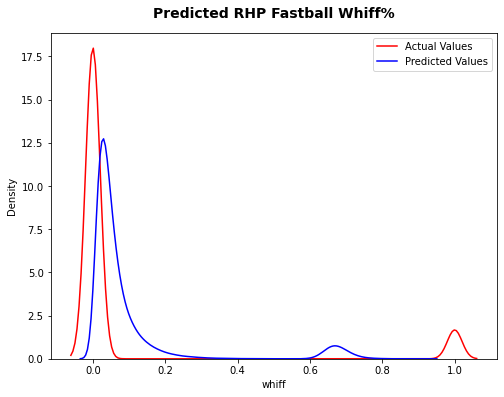

In [8]:
plt.figure(figsize = (8, 6))

ax = sns.distplot(y, hist = False, color = 'r', label = 'Actual Values')
sns.distplot(pred, hist = False, color = 'b', label = 'Predicted Values', ax = ax)
plt.legend()
plt.title('Predicted RHP Fastball Whiff%', fontsize = 14, fontweight = 'bold', pad = 15);

### RHP Fastball Stuff+ Table

In [9]:
rhp_fb['xWhiff'] = pred * 100
rhp_fb['n_pitches'] = 1
rhp_fb['Stuff+'] = 100 * (rhp_fb['xWhiff'] / rhp_fb['xWhiff'].mean())
#rhp_fb.head()

grouped_fb_r = rhp_fb.groupby(['player_name', 'year', 'p_throws', 'pitch_type'], 
                              as_index = False)['n_pitches'].sum()

avg_fb_r = rhp_fb.groupby(['player_name', 'year', 'p_throws', 'pitch_type'], 
                          as_index = False)['velo', 'pfx_x', 'pfx_z', 'release_pos_x', 'release_pos_z', 
                                            'release_extension', 'Stuff+'].mean()
fbr_stuff = pd.merge(avg_fb_r, grouped_fb_r, how = 'left', on = ['player_name', 'year', 'p_throws', 'pitch_type'])
fbr_stuff = fbr_stuff.loc[fbr_stuff['n_pitches'] >= 100]
fbr_stuff = fbr_stuff.round(1)
fbr_stuff.insert(3, 'n_pitches', fbr_stuff.pop('n_pitches'))
fbr_stuff.sort_values(by = 'Stuff+', ascending = False).head(10)

,player_name,year,p_throws,n_pitches,pitch_type,velo,pfx_x,pfx_z,release_pos_x,release_pos_z,release_extension,Stuff+
353,"Coonrod, Sam",2021,R,139,FF,98.5,9.7,16.0,1.6,6.0,6.6,204.7
495,"Fairbanks, Pete",2022,R,216,FF,99.0,0.1,20.7,0.3,7.0,6.6,200.4
1221,"O'Day, Darren",2022,R,160,FF,86.0,11.3,9.9,2.7,3.7,6.7,198.2
1057,"Maton, Phil",2021,R,577,FF,91.5,-0.8,13.3,1.7,5.4,7.1,187.8
1858,"deGrom, Jacob",2021,R,704,FF,99.2,9.1,16.4,1.1,5.5,6.9,185.1
1501,"Sewald, Paul",2021,R,644,FF,92.3,12.5,13.7,3.8,4.5,6.5,184.7
539,"Floro, Dylan",2021,R,328,FF,93.8,9.8,15.3,3.3,6.1,6.3,183.2
589,"García, Yimi",2021,R,370,FF,96.0,6.7,12.5,2.8,5.0,5.9,182.2
274,"Castillo, Luis",2022,R,802,FF,97.1,11.3,13.7,2.8,5.3,5.6,181.9
783,"Houck, Tanner",2021,R,183,SI,93.1,14.7,-0.8,2.9,5.4,6.1,179.3


Velocity, Spin Rate, HB, VB, Release Side, Release Height, Release Extension

### RHP Fastball Stuff+ Movement Plot

RHP Fastball Avg Stuff+: 100


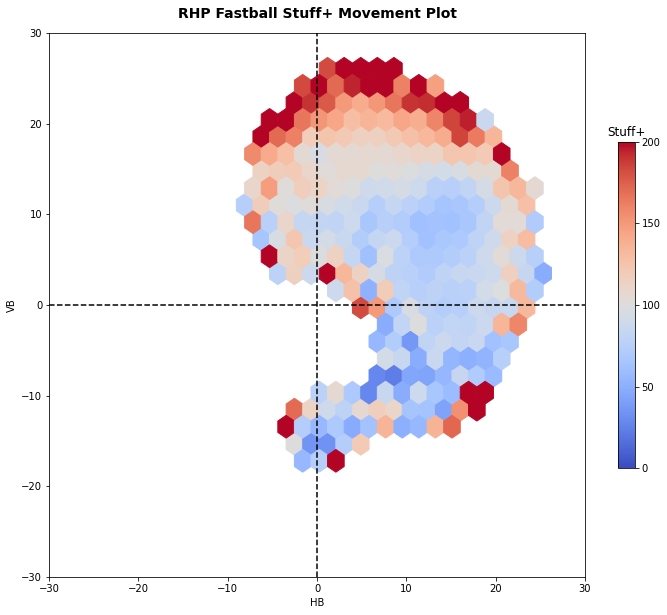

In [10]:
plt.figure(figsize = (12, 10))

plt.hexbin(rhp_fb['pfx_x'], rhp_fb['pfx_z'], C = rhp_fb['Stuff+'], cmap = 'coolwarm', 
           mincnt = 5, gridsize = 25)
cb = plt.colorbar(ticks = [0, 50, 100, 150, 200], shrink = .6)
cb.ax.set_title('Stuff+'), plt.clim(0, 200)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Fastball Stuff+ Movement Plot', fontsize = 14, fontweight = 'bold', pad = 15);
print('RHP Fastball Avg Stuff+:', round(rhp_fb['Stuff+'].mean()))

## Fastball LHP Grouped

#### 4-Seam, Sinker

In [11]:
print('Baseline LHP Fastball Whiff% Accuracy Score:', round(lhp_fb.whiff.mean(), 2))

Baseline LHP Fastball Whiff% Accuracy Score: 0.09


In [12]:
features_fb_l = lhp_fb.select_dtypes([np.number])
X = features_fb_l.drop(columns = ['whiff'])
y = features_fb_l['whiff']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 1)

rf = RandomForestRegressor(n_estimators = 500, n_jobs = -1, random_state = 1).fit(X_train, y_train)

pred_fb_l = rf.predict(X_test)
pred = rf.predict(X)

print('R2 Score:', round((metrics.r2_score(y_test, pred_fb_l)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_fb_l)), 3))
print('Test MAE:', round(metrics.mean_absolute_error(y_test, pred_fb_l), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Score: -0.038
Test RMSE: 0.285
Test MAE: 0.171 

R2 Score: 0.634
RMSE: 0.169
MAE: 0.09


- Average LHP FB Run Value prediction error is .26 runs

### LHP Fastball Actual & Predicted Values

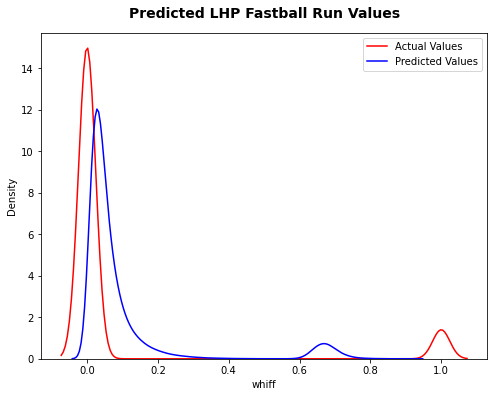

In [13]:
plt.figure(figsize = (8, 6))

ax = sns.distplot(y, hist = False, color = 'r', label = 'Actual Values')
sns.distplot(pred, hist = False, color = 'b', label = 'Predicted Values', ax = ax)
plt.legend()
plt.title('Predicted LHP Fastball Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Fastball Stuff+ Table

In [14]:
lhp_fb['xWhiff'] = pred * 100
lhp_fb['n_pitches'] = 1
lhp_fb['Stuff+'] = 100 * (lhp_fb['xWhiff'] / lhp_fb['xWhiff'].mean())
#lhp_fb.head()

grouped_fb_l = lhp_fb.groupby(['player_name', 'year', 'p_throws', 'pitch_type'], 
                              as_index = False)['n_pitches'].sum()

avg_fb_l = lhp_fb.groupby(['player_name', 'year', 'p_throws', 'pitch_type'], 
                          as_index = False)['velo', 'pfx_x', 'pfx_z', 'release_pos_x', 'release_pos_z', 
                                            'release_extension', 'Stuff+'].mean()
fbl_stuff = pd.merge(avg_fb_l, grouped_fb_l, how = 'left', on = ['player_name', 'year', 'p_throws', 'pitch_type'])
fbl_stuff = fbl_stuff.loc[fbl_stuff['n_pitches'] >= 100]
fbl_stuff = fbl_stuff.round(1)
fbl_stuff.insert(3, 'n_pitches', fbl_stuff.pop('n_pitches'))
fbl_stuff.sort_values(by = 'Stuff+', ascending = False).head(10)

,player_name,year,p_throws,n_pitches,pitch_type,velo,pfx_x,pfx_z,release_pos_x,release_pos_z,release_extension,Stuff+
257,"Hernández, Darwinzon",2022,L,102,FF,94.3,-3.0,13.4,-2.8,4.8,6.8,217.1
232,"Hader, Josh",2021,L,593,FF,96.4,-9.8,17.4,-3.1,5.3,6.7,211.6
646,"Vesia, Alex",2021,L,471,FF,93.8,-6.8,19.7,-1.3,5.8,6.5,192.1
633,"Thielbar, Caleb",2022,L,484,FF,92.8,-3.2,19.4,-0.3,6.1,6.3,168.6
509,"Rodón, Carlos",2021,L,1302,FF,95.4,-7.9,17.6,-2.0,6.7,6.1,166.2
647,"Vesia, Alex",2022,L,568,FF,94.2,-5.0,19.5,-0.9,5.8,6.5,166.1
483,"Quijada, José",2022,L,559,FF,94.5,-5.9,15.5,-2.3,5.4,6.6,162.3
254,"Hentges, Sam",2022,L,238,SI,95.7,-14.1,10.3,-1.9,6.4,6.7,158.4
159,"Diekman, Jake",2022,L,503,FF,95.6,-15.8,12.6,-3.4,5.5,6.4,158.0
394,"Minter, A.J.",2022,L,532,FF,96.6,-6.5,17.3,-2.3,5.7,6.2,157.8


### LHP Fastball Stuff+ Movement Plot

LHP Fastball Avg Stuff+: 100


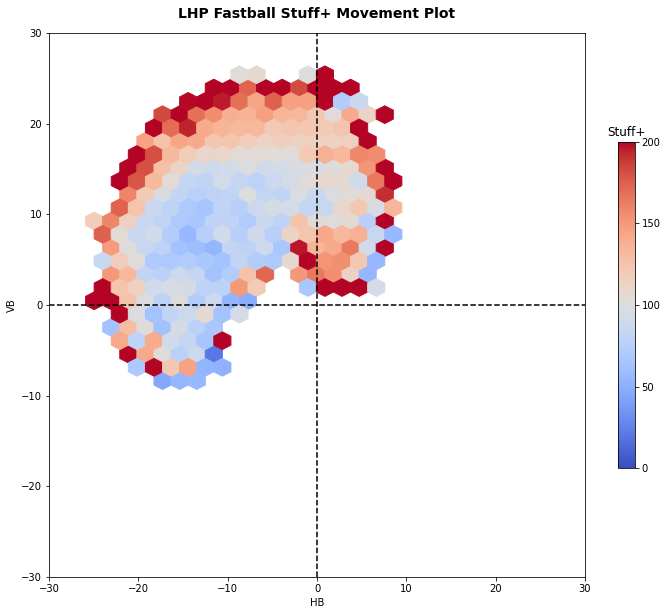

In [15]:
plt.figure(figsize = (12, 10))

plt.hexbin(lhp_fb['pfx_x'], lhp_fb['pfx_z'], C = lhp_fb['Stuff+'], cmap = 'coolwarm', 
           mincnt = 2, gridsize = 23)
cb = plt.colorbar(ticks = [0, 50, 100, 150, 200], shrink = .6)
cb.ax.set_title('Stuff+'), plt.clim(0, 200)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Fastball Stuff+ Movement Plot', fontsize = 14, fontweight = 'bold', pad = 15);
print('LHP Fastball Avg Stuff+:', round(lhp_fb['Stuff+'].mean()))

## Breaking Ball RHP

#### Cutter, Slider, Curveball

In [16]:
print('Baseline RHP Breaking Ball Whiff% Accuracy Score:', round(rhp_bb.whiff.mean(), 2))

Baseline RHP Breaking Ball Whiff% Accuracy Score: 0.14


In [17]:
features_bb_r = rhp_bb.select_dtypes([np.number])
X = features_bb_r.drop(columns = ['whiff'])
y = features_bb_r['whiff']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 1)

rf = RandomForestRegressor(n_estimators = 500, n_jobs = -1, random_state = 1).fit(X_train, y_train)

pred_bb_r = rf.predict(X_test)
pred = rf.predict(X)

print('R2 Test Score:', round((metrics.r2_score(y_test, pred_bb_r)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_bb_r)), 3))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_bb_r), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Test Score: -0.024
Test RMSE: 0.354
MAE: 0.257 

R2 Score: 0.64
Test RMSE: 0.21
MAE: 0.136


- Average RHP Breaking Ball Run Value prediction error is .26 runs

### RHP Breaking Ball Actual & Predicted Values

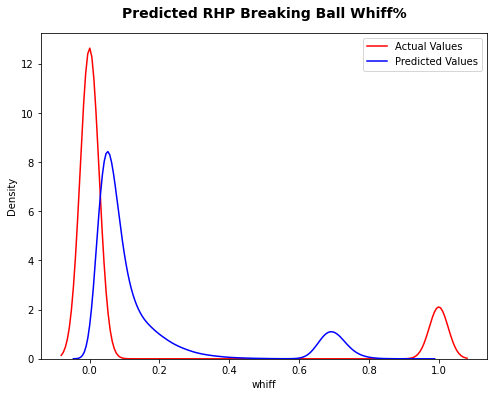

In [18]:
plt.figure(figsize = (8, 6))

ax = sns.distplot(y, hist = False, color = 'r', label = 'Actual Values')
sns.distplot(pred, hist = False, color = 'b', label = 'Predicted Values', ax = ax)
plt.legend()
plt.title('Predicted RHP Breaking Ball Whiff%', fontsize = 14, fontweight = 'bold', pad = 15);

### RHP Breaking Ball Stuff+ Table

In [19]:
rhp_bb['xWhiff'] = pred * 100
rhp_bb['n_pitches'] = 1
rhp_bb['Stuff+'] = 100 * (rhp_bb['xWhiff'] / rhp_bb['xWhiff'].mean())
#rhp_bb.head()

grouped_bb_r = rhp_bb.groupby(['player_name', 'year', 'p_throws', 'pitch_type'], 
                              as_index = False)['n_pitches'].sum()

avg_bb_r = rhp_bb.groupby(['player_name', 'year', 'p_throws', 'pitch_type'], 
                          as_index = False)['velo', 'pfx_x', 'pfx_z', 'release_pos_x', 'release_pos_z', 
                                            'release_extension', 'Stuff+'].mean()
bbr_stuff = pd.merge(avg_bb_r, grouped_bb_r, how = 'left', on = ['player_name', 'year', 'p_throws', 'pitch_type'])
bbr_stuff = bbr_stuff.loc[bbr_stuff['n_pitches'] >= 100]
bbr_stuff = bbr_stuff.round(1)
bbr_stuff.insert(3, 'n_pitches', bbr_stuff.pop('n_pitches'))
bbr_stuff.sort_values(by = 'Stuff+', ascending = False).head(10)

,player_name,year,p_throws,n_pitches,pitch_type,velo,pfx_x,pfx_z,release_pos_x,release_pos_z,release_extension,Stuff+
677,"Glasnow, Tyler",2021,R,183,CU,83.5,-4.6,-17.5,1.5,6.3,7.2,214.5
2051,"deGrom, Jacob",2021,R,409,SL,91.6,-4.7,3.5,1.1,5.5,6.8,209.9
487,"Díaz, Edwin",2022,R,514,SL,90.8,-1.5,4.3,2.2,5.1,7.1,202.2
789,"Helsley, Ryan",2022,R,293,SL,89.2,-4.6,2.2,0.5,6.0,6.7,187.0
2053,"deGrom, Jacob",2022,R,369,SL,92.6,-3.6,5.2,1.5,5.6,6.6,184.5
797,"Hendriks, Liam",2021,R,235,SL,89.0,-1.9,3.2,1.7,5.9,6.9,181.2
1484,"Pressly, Ryan",2022,R,239,SL,89.7,-5.1,2.8,0.3,6.1,6.1,178.1
1498,"Rainey, Tanner",2022,R,142,SL,88.3,-3.6,1.7,2.9,6.1,6.4,177.5
10,"Abreu, Bryan",2022,R,408,SL,88.4,-8.2,-2.6,2.2,5.7,6.4,176.5
1375,"Ortiz, Luis L.",2022,R,102,SL,87.7,-4.5,0.4,1.4,5.3,6.5,173.6


### RHP Breaking Ball Stuff+ Movement Plot

RHP Breaking Ball Avg Stuff+: 100


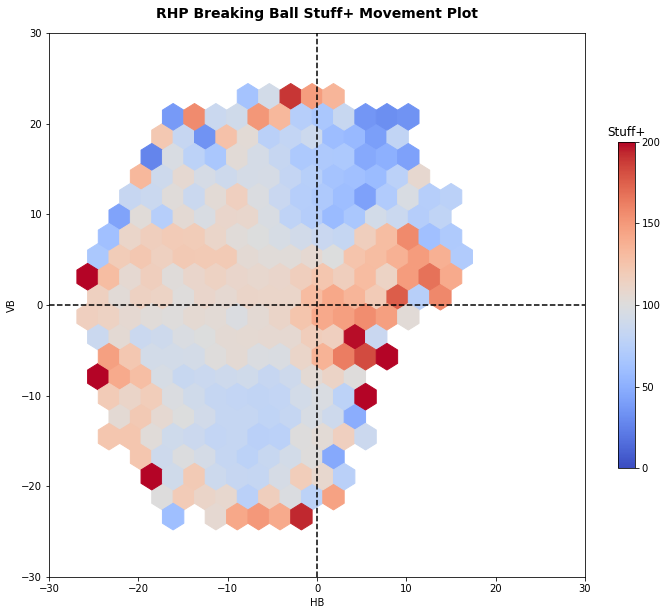

In [20]:
plt.figure(figsize = (12, 10))

plt.hexbin(rhp_bb['pfx_x'], rhp_bb['pfx_z'], C = rhp_bb['Stuff+'], cmap = 'coolwarm', 
           mincnt = 3, gridsize = 23)
cb = plt.colorbar(ticks = [0, 50, 100, 150, 200], shrink = .6)
cb.ax.set_title('Stuff+'), plt.clim(0, 200)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Breaking Ball Stuff+ Movement Plot', fontsize = 14, fontweight = 'bold', pad = 15);
print('RHP Breaking Ball Avg Stuff+:', round(rhp_bb['Stuff+'].mean()))

## Breaking Ball LHP
#### Slider, Cutter, Curveball, Knuckle Curve

In [21]:
print('Baseline LHP Breaking Ball Whiff% Accuracy Score:', round(lhp_bb.whiff.mean(), 2))

Baseline LHP Breaking Ball Whiff% Accuracy Score: 0.14


In [22]:
features_bb_l = lhp_bb.select_dtypes([np.number])
X = features_bb_l.drop(columns = ['whiff'])
y = features_bb_l['whiff']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 1)

rf = RandomForestRegressor(n_estimators = 500, n_jobs = -1, random_state = 1).fit(X_train, y_train)

pred_bb_l = rf.predict(X_test)
pred = rf.predict(X)

print('R2 Test Score:', round((metrics.r2_score(y_test, pred_bb_l)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_bb_l)), 3))
print('Test MAE:', round(metrics.mean_absolute_error(y_test, pred_bb_l), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Test Score: -0.018
Test RMSE: 0.354
Test MAE: 0.255 

R2 Score: 0.638
RMSE: 0.21
MAE: 0.133


- Average LHP Breaking Ball Whiff prediction error is 35.3%

### LHP Breaking Ball Actual & Predicted Values

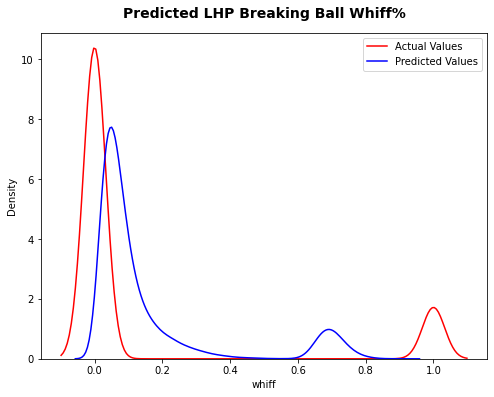

In [23]:
plt.figure(figsize = (8, 6))

ax = sns.distplot(y, hist = False, color = 'r', label = 'Actual Values')
sns.distplot(pred, hist = False, color = 'b', label = 'Predicted Values', ax = ax)
plt.legend()
plt.title('Predicted LHP Breaking Ball Whiff%', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Breaking Ball Stuff+ Table

In [24]:
lhp_bb['xWhiff'] = pred * 100
lhp_bb['n_pitches'] = 1
lhp_bb['Stuff+'] = 100 * (lhp_bb['xWhiff'] / lhp_bb['xWhiff'].mean())
#lhp_bb.head()

grouped_bb_l = lhp_bb.groupby(['player_name', 'year', 'p_throws', 'pitch_type'], 
                              as_index = False)['n_pitches'].sum()

avg_bb_l = lhp_bb.groupby(['player_name', 'year', 'p_throws', 'pitch_type'], 
                          as_index = False)['velo', 'pfx_x', 'pfx_z', 'release_pos_x', 'release_pos_z', 
                                            'release_extension', 'Stuff+'].mean()
bbl_stuff = pd.merge(avg_bb_l, grouped_bb_l, how = 'left', on = ['player_name', 'year', 'p_throws', 'pitch_type'])
bbl_stuff = bbl_stuff.loc[bbl_stuff['n_pitches'] >= 100]
bbl_stuff = bbl_stuff.round(1)
bbl_stuff.insert(3, 'n_pitches', bbl_stuff.pop('n_pitches'))
bbl_stuff.sort_values(by = 'Stuff+', ascending = False).head(10)

,player_name,year,p_throws,n_pitches,pitch_type,velo,pfx_x,pfx_z,release_pos_x,release_pos_z,release_extension,Stuff+
28,"Alvarado, José",2021,L,170,FC,94.1,1.3,5.1,-1.0,6.4,6.7,199.1
30,"Alvarado, José",2022,L,372,FC,93.8,1.9,5.6,-1.2,6.5,6.7,193.2
112,"Chafin, Andrew",2021,L,250,SL,82.5,1.1,-1.8,-1.6,6.3,6.6,189.6
113,"Chafin, Andrew",2022,L,275,SL,82.9,0.3,-0.6,-1.9,6.2,6.5,185.8
614,"Smith, Will",2021,L,443,SL,82.2,5.9,3.2,-1.7,6.6,6.3,175.1
334,"Lee, Dylan",2022,L,358,SL,83.8,3.2,4.4,-1.7,6.4,6.5,170.9
85,"Brothers, Rex",2021,L,344,SL,86.2,1.0,1.4,-2.0,5.9,5.9,164.9
587,"Scott, Tanner",2021,L,531,SL,88.5,5.7,-1.7,-2.6,5.5,6.3,164.8
399,"McClanahan, Shane",2022,L,380,SL,89.3,3.6,3.7,-1.1,6.1,6.8,164.2
531,"Raley, Brooks",2021,L,251,SL,81.8,16.6,3.7,-2.7,5.8,5.8,164.1


### LHP Breaking Ball Stuff+ Movement Plot

LHP Breaking Ball Avg Stuff+: 100


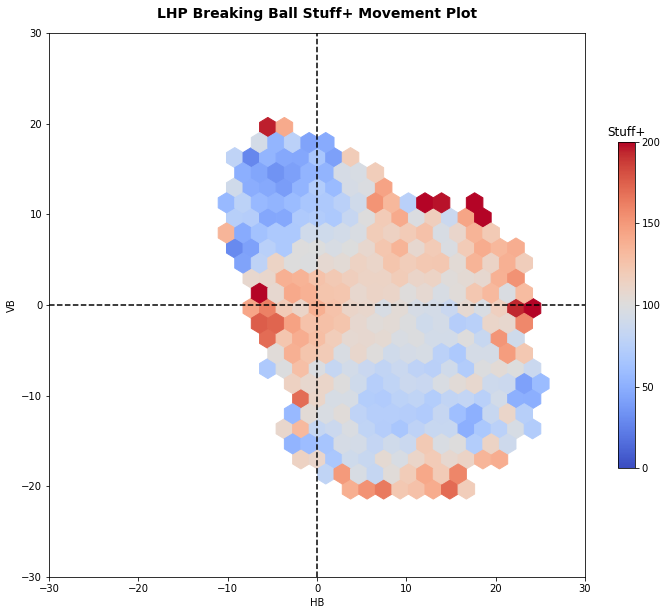

In [25]:
plt.figure(figsize = (12, 10))

plt.hexbin(lhp_bb['pfx_x'], lhp_bb['pfx_z'], C = lhp_bb['Stuff+'], cmap = 'coolwarm', 
           mincnt = 5, gridsize = 25)
cb = plt.colorbar(ticks = [0, 50, 100, 150, 200], shrink = .6)
cb.ax.set_title('Stuff+'), plt.clim(0, 200)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Breaking Ball Stuff+ Movement Plot', fontsize = 14, fontweight = 'bold', pad = 15);
print('LHP Breaking Ball Avg Stuff+:', round(lhp_bb['Stuff+'].mean()))

## Off Speed RHP

#### Changeup, Splitter

In [26]:
print('Baseline RHP Off Speed Whiff% Accuracy Score:', round(rhp_os.whiff.mean(), 2))

Baseline RHP Off Speed Whiff% Accuracy Score: 0.15


In [27]:
features_os_r = rhp_os.select_dtypes([np.number])
X = features_os_r.drop(columns = ['whiff'])
y = features_os_r['whiff']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 1)

rf = RandomForestRegressor(n_estimators = 500, n_jobs = -1, random_state = 1).fit(X_train, y_train)

pred_os_r = rf.predict(X_test)
pred = rf.predict(X)

print('R2 Score:', round((metrics.r2_score(y_test, pred_os_r)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_os_r)), 3))
print('Test MAE:', round(metrics.mean_absolute_error(y_test, pred_os_r), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Score: -0.039
Test RMSE: 0.362
Test MAE: 0.27 

R2 Score: 0.639
RMSE: 0.215
MAE: 0.143


- Average RHP Off Speed Whiff prediction error is 36.2%

### RHP Off Speed Actual & Predicted Run Values

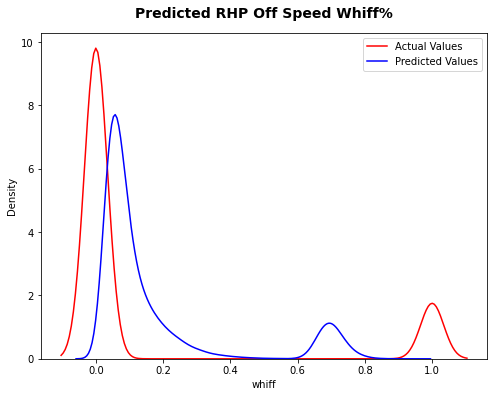

In [28]:
plt.figure(figsize = (8, 6))

ax = sns.distplot(y, hist = False, color = 'r', label = 'Actual Values')
sns.distplot(pred, hist = False, color = 'b', label = 'Predicted Values', ax = ax)
plt.legend()
plt.title('Predicted RHP Off Speed Whiff%', fontsize = 14, fontweight = 'bold', pad = 15);

### RHP Off Speed Stuff+ Table

In [29]:
rhp_os['xWhiff'] = pred * 100
rhp_os['n_pitches'] = 1
rhp_os['Stuff+'] = 100 * (rhp_os['xWhiff'] / rhp_os['xWhiff'].mean())
#rhp_os.head()

grouped_os_r = rhp_os.groupby(['player_name', 'year', 'p_throws', 'pitch_type'], 
                              as_index = False)['n_pitches'].sum()

avg_os_r = rhp_os.groupby(['player_name', 'year', 'p_throws', 'pitch_type'], 
                          as_index = False)['velo', 'pfx_x', 'pfx_z', 'release_pos_x', 'release_pos_z', 
                                            'release_extension', 'Stuff+'].mean()
osr_stuff = pd.merge(avg_os_r, grouped_os_r, how = 'left', on = ['player_name', 'year', 'p_throws', 'pitch_type'])
osr_stuff = osr_stuff.loc[osr_stuff['n_pitches'] >= 100]
osr_stuff = osr_stuff.round(1)
osr_stuff.insert(3, 'n_pitches', osr_stuff.pop('n_pitches'))
osr_stuff.sort_values(by = 'Stuff+', ascending = False).head(10)

,player_name,year,p_throws,n_pitches,pitch_type,velo,pfx_x,pfx_z,release_pos_x,release_pos_z,release_extension,Stuff+
66,"Bautista, Félix",2022,R,256,FS,88.5,7.5,6.8,0.9,7.0,6.4,189.3
528,"Leiter Jr., Mark",2022,R,237,FS,84.2,6.4,4.5,1.2,5.8,6.6,170.9
659,"Ohtani, Shohei",2022,R,310,FS,89.3,5.5,2.5,2.1,6.1,6.9,169.1
658,"Ohtani, Shohei",2021,R,366,FS,88.1,4.9,2.4,1.8,6.2,6.8,162.6
618,"Montas, Frankie",2021,R,677,FS,87.5,11.5,3.8,1.2,6.2,6.0,159.5
1004,"deGrom, Jacob",2021,R,109,CH,91.4,14.2,2.8,1.0,5.4,7.0,159.0
642,"Neris, Hector",2022,R,305,FS,85.1,10.7,-0.7,1.6,6.1,6.2,158.4
446,"Iglesias, Raisel",2021,R,254,CH,89.4,17.2,3.8,1.9,5.5,6.1,156.3
969,"Williams, Devin",2022,R,603,CH,83.4,19.0,-3.0,2.1,5.2,7.3,155.6
968,"Williams, Devin",2021,R,621,CH,83.7,17.0,-4.2,2.3,5.4,6.8,155.3


### RHP Off Speed Stuff+ Movement Plot

RHP Off-Speed Avg Stuff+: 100


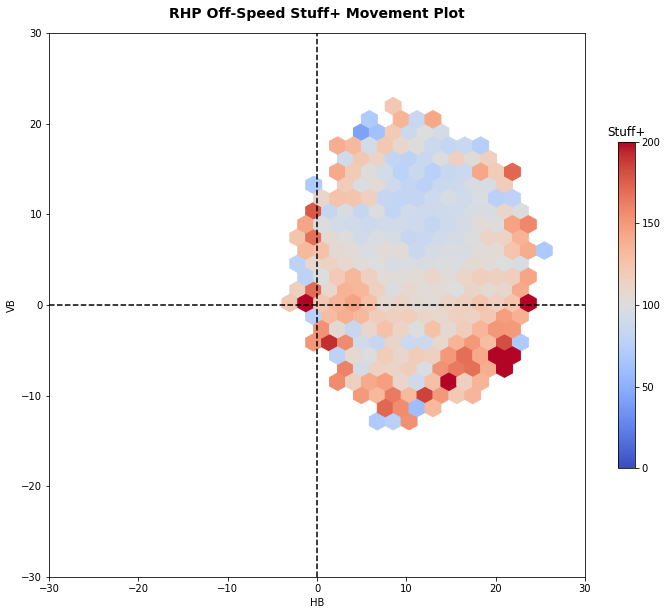

In [30]:
plt.figure(figsize = (12, 10))

plt.hexbin(rhp_os['pfx_x'], rhp_os['pfx_z'], C = rhp_os['Stuff+'], cmap = 'coolwarm', 
           mincnt = 5, gridsize = 25)
cb = plt.colorbar(ticks = [0, 50, 100, 150, 200], shrink = .6)
cb.ax.set_title('Stuff+'), plt.clim(0, 200)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Off-Speed Stuff+ Movement Plot', fontsize = 14, fontweight = 'bold', pad = 15);
print('RHP Off-Speed Avg Stuff+:', round(rhp_os['Stuff+'].mean()))

## Off Speed LHP
#### Changeup, Splitter

In [31]:
print('Baseline LHP Off Speed Whiff% Accuracy Score:', round(lhp_os.whiff.mean(), 2))

Baseline LHP Off Speed Whiff% Accuracy Score: 0.15


In [32]:
features_os_l = lhp_os.select_dtypes([np.number])
X = features_os_l.drop(columns = ['whiff'])
y = features_os_l['whiff']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 1)

rf = RandomForestRegressor(n_estimators = 500, n_jobs = -1, random_state = 1).fit(X_train, y_train)

pred_os_l = rf.predict(X_test)
pred = rf.predict(X)

print('R2 Score:', round((metrics.r2_score(y_test, pred_os_l)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_os_l)), 3))
print('Test MAE:', round(metrics.mean_absolute_error(y_test, pred_os_l), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Score: -0.037
Test RMSE: 0.372
Test MAE: 0.274 

R2 Score: 0.626
RMSE: 0.219
MAE: 0.142


- Average RHP Off Speed Run Value prediction error is .27 runs

### LHP Off Speed Actual & Predicted Values

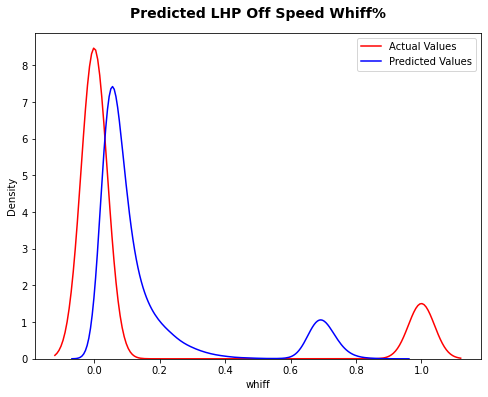

In [33]:
plt.figure(figsize = (8, 6))

ax = sns.distplot(y, hist = False, color = 'r', label = 'Actual Values')
sns.distplot(pred, hist = False, color = 'b', label = 'Predicted Values', ax = ax)
plt.legend()
plt.title('Predicted LHP Off Speed Whiff%', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Off Speed Stuff+ Table

In [34]:
lhp_os['xWhiff'] = pred * 100
lhp_os['n_pitches'] = 1
lhp_os['Stuff+'] = 100 * (lhp_os['xWhiff'] / lhp_os['xWhiff'].mean())
#lhp_os.head()

grouped_os_l = lhp_os.groupby(['player_name', 'year', 'p_throws', 'pitch_type'], 
                              as_index = False)['n_pitches'].sum()

avg_os_l = lhp_os.groupby(['player_name', 'year', 'p_throws', 'pitch_type'], 
                          as_index = False)['velo', 'pfx_x', 'pfx_z', 'release_pos_x', 'release_pos_z', 
                                            'release_extension', 'Stuff+'].mean()
osl_stuff = pd.merge(avg_os_l, grouped_os_l, how = 'left', on = ['player_name', 'year', 'p_throws', 'pitch_type'])
osl_stuff = osl_stuff.loc[osl_stuff['n_pitches'] >= 100]
osl_stuff = osl_stuff.round(1)
osl_stuff.insert(3, 'n_pitches', osl_stuff.pop('n_pitches'))
osl_stuff.sort_values(by = 'Stuff+', ascending = False).head(10)

,player_name,year,p_throws,n_pitches,pitch_type,velo,pfx_x,pfx_z,release_pos_x,release_pos_z,release_extension,Stuff+
56,"Chapman, Aroldis",2021,L,111,FS,88.4,-2.7,-2.7,-0.4,6.1,7.4,235.4
213,"Moore, Matt",2022,L,196,CH,85.0,-17.1,8.7,-1.4,6.4,6.2,155.7
280,"Sandoval, Patrick",2021,L,423,CH,84.6,-13.1,10.0,-1.8,6.1,6.1,150.4
211,"Montgomery, Jordan",2022,L,603,CH,82.3,-10.9,11.9,-1.8,6.4,6.8,147.4
195,"McClanahan, Shane",2022,L,624,CH,87.7,-16.0,10.5,-1.0,6.1,6.9,146.4
322,"Suter, Brent",2022,L,264,CH,77.2,-10.0,11.0,-3.1,6.3,6.9,146.3
296,"Skubal, Tarik",2022,L,285,CH,83.6,-13.4,6.8,-2.1,6.3,6.2,141.9
266,"Rodríguez, Joely",2022,L,322,CH,87.8,-11.3,0.5,-3.8,5.4,6.3,140.6
183,"Luzardo, Jesús",2022,L,351,CH,87.1,-15.5,8.4,-2.1,5.8,5.7,140.1
301,"Smith, Caleb",2022,L,268,CH,83.6,-13.6,15.4,-1.6,6.2,5.8,139.4


### LHP Off Speed Stuff+ Movement Plot

LHP Off-Speed Avg Stuff+: 100


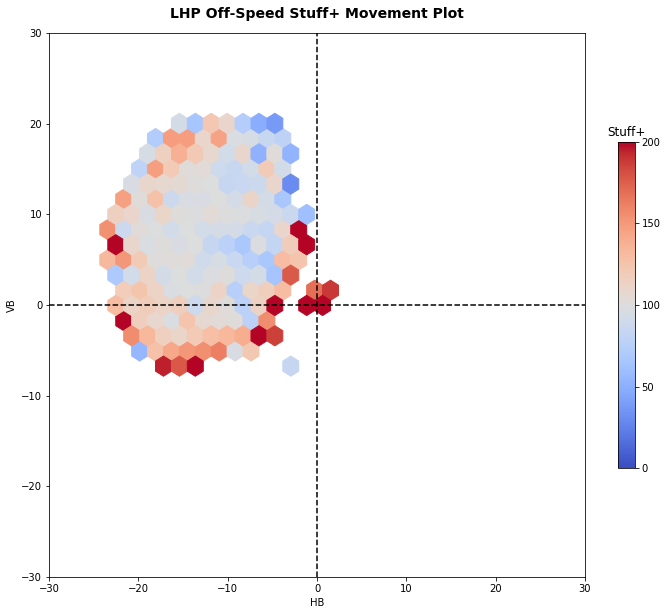

In [35]:
plt.figure(figsize = (12, 10))

plt.hexbin(lhp_os['pfx_x'], lhp_os['pfx_z'], C = lhp_os['Stuff+'], cmap = 'coolwarm', 
           mincnt = 5, gridsize = 20)
cb = plt.colorbar(ticks = [0, 50, 100, 150, 200], shrink = .6)
cb.ax.set_title('Stuff+'), plt.clim(0, 200)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Off-Speed Stuff+ Movement Plot', fontsize = 14, fontweight = 'bold', pad = 15);
print('LHP Off-Speed Avg Stuff+:', round(lhp_os['Stuff+'].mean()))

## Save Grouped RV Tables to CSV

In [36]:
xrv_grouped = pd.concat([rhp_fb, lhp_fb, rhp_bb, lhp_bb, rhp_os, lhp_os], ignore_index = True)
xrv_grouped.fillna(0, inplace = True)
xrv_grouped.to_csv('../data/xwhiff_grouped_21_22.csv')

rv_table = pd.concat([fbr_stuff, fbl_stuff, bbr_stuff, bbl_stuff, osr_stuff, osl_stuff])
rv_table.to_csv('../data/stuff_table_21_22.csv')